Loading UNet model for segmentation...
Loading input image for segmentation...
Performing segmentation...
1/1 [==============================] - 0s 493ms/step
Masked image saved at 'Classified_Before/RuralOne/masked_image.png'.
Detecting road edges on the masked image...
Total cropped images generated: 535
Loading concrete/non-concrete classifier model...
Performing classification on each cropped image...
1/1 [==============================] - 0s 95ms/step
Image: Classified_After\Rural\Y_masked_image_466_0_470_5.jpg, Coordinates: [466, 470, 0, 5], Class: Non-Concrete, Confidence: 0.60
1/1 [==============================] - 0s 20ms/step
Image: Classified_After\Rural\Y_masked_image_465_5_469_10.jpg, Coordinates: [465, 469, 5, 10], Class: Non-Concrete, Confidence: 0.93
1/1 [==============================] - 0s 19ms/step
Image: Classified_After\Rural\Y_masked_image_464_10_468_15.jpg, Coordinates: [464, 468, 10, 15], Class: Concrete, Confidence: 0.88
1/1 [==============================] - 0

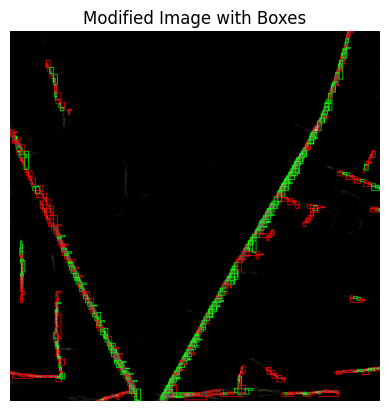


Summary of Predictions and Coordinates:
Path: Classified_After\Rural\Y_masked_image_466_0_470_5.jpg, Coordinates: [466, 470, 0, 5], Class: Non-Concrete, Confidence: 0.60
Path: Classified_After\Rural\Y_masked_image_465_5_469_10.jpg, Coordinates: [465, 469, 5, 10], Class: Non-Concrete, Confidence: 0.93
Path: Classified_After\Rural\Y_masked_image_464_10_468_15.jpg, Coordinates: [464, 468, 10, 15], Class: Concrete, Confidence: 0.88
Path: Classified_After\Rural\Y_masked_image_463_15_467_20.jpg, Coordinates: [463, 467, 15, 20], Class: Concrete, Confidence: 0.96
Path: Classified_After\Rural\Y_masked_image_462_20_466_25.jpg, Coordinates: [462, 466, 20, 25], Class: Non-Concrete, Confidence: 0.92
Path: Classified_After\Rural\Y_masked_image_460_25_464_30.jpg, Coordinates: [460, 464, 25, 30], Class: Concrete, Confidence: 0.75
Path: Classified_After\Rural\Y_masked_image_458_30_463_35.jpg, Coordinates: [458, 463, 30, 35], Class: Concrete, Confidence: 0.95
Path: Classified_After\Rural\Y_masked_image

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

###############################
# First Script: UNet Segmentation
###############################

def load_single_image(img_path, shape=512):
    """
    Loads an image and resizes it to the given shape.
    """
    try:
        img = plt.imread(img_path)
        img = cv2.resize(img, (shape, shape))
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def predict_single_image(img, model):
    """
    Runs the UNet model on the image and returns the predicted mask along with the original image.
    """
    img_proc = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img_proc)
    return prediction[0], img

def save_masked_image(image, mask, output_path):
    """
    Applies the predicted mask to the image and saves the resulting masked image.
    Assumes the mask has at least one channel.
    """
    # Use the first channel of the mask
    mask = mask[:, :, 0]
    # Multiply mask with the original image to "mask" it out
    masked_image = image * np.expand_dims(mask, axis=-1)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.imsave(output_path, masked_image.astype(np.uint8))

# Input for segmentation
input_image_path = r'test20\7502_sat.jpg'      # Update this path to your input image
masked_output_path = 'Classified_Before/RuralOne/masked_image.png'

# Load the UNet segmentation model
unet_model_path = "Models/unet512.h5"          # Update if necessary
print("Loading UNet model for segmentation...")
unet = load_model(unet_model_path)

# Process the input image using UNet segmentation
print("Loading input image for segmentation...")
input_image = load_single_image(input_image_path, shape=512)
if input_image is None:
    print("Failed to load the input image for segmentation. Exiting.")
    exit()

print("Performing segmentation...")
segmentation_mask, processed_image = predict_single_image(input_image, unet)
save_masked_image(processed_image, segmentation_mask, masked_output_path)
print(f"Masked image saved at '{masked_output_path}'.")

###############################
# Second Script: Road Edge Detection & Cropping
###############################

def draw_rectangle(image, yi, yf, xi, xf, color=(0, 255, 0)):
    """
    Draws a rectangle on the image.
    """
    start_point = (xi, yi)
    end_point = (xf, yf)
    thickness = 1  # Thickness of 1 px
    cv2.rectangle(image, start_point, end_point, color, thickness)
    return image

def detect_road_edges_Y(image_path, slide_height=5, gap_threshold=10):
    """
    Scans the image row-wise to detect continuous edge segments.
    Returns a list of coordinate sets [start_x, end_x, y, y+slide_height].
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return []
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    height, width = edges.shape
    road_coordinates = []
    
    for y in range(0, height, slide_height):
        row = edges[y, :]
        x_indices = np.where(row > 0)[0]
        
        if len(x_indices) > 0:
            roads = []
            temp_road = [x_indices[0]]
            for i in range(1, len(x_indices)):
                if x_indices[i] - x_indices[i - 1] > gap_threshold:
                    roads.append(temp_road)
                    temp_road = []
                temp_road.append(x_indices[i])
            if temp_road:
                roads.append(temp_road)
            
            for road in roads:
                start_x, end_x = road[0], road[-1]
                road_coordinates.append([start_x, end_x, y, y + slide_height])
    
    return road_coordinates

def detect_road_edges_X(image_path, slide_height=5, gap_threshold=10):
    """
    Scans the image column-wise to detect continuous edge segments.
    Returns a list of coordinate sets [x, x+slide_height, start_y, end_y].
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return []
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    height, width = edges.shape
    road_coordinates = []
    
    for x in range(0, width, slide_height):
        column = edges[:, x]
        y_indices = np.where(column > 0)[0]
        
        if len(y_indices) > 0:
            roads = []
            temp_road = [y_indices[0]]
            for i in range(1, len(y_indices)):
                if y_indices[i] - y_indices[i - 1] > gap_threshold:
                    roads.append(temp_road)
                    temp_road = []
                temp_road.append(y_indices[i])
            if temp_road:
                roads.append(temp_road)
            
            for road in roads:
                start_y, end_y = road[0], road[-1]
                road_coordinates.append([x, x + slide_height, start_y, end_y])
    
    return road_coordinates

def crop_and_save_image(image, xi, xf, yi, yf, save_directory, file_name):
    """
    Crops the image using the provided coordinates and saves it.
    Returns the path to the saved cropped image.
    """
    cropped_image = image[yi:yf, xi:xf]
    
    if cropped_image.size == 0:
        print(f"Warning: Empty crop for {file_name}, skipping save.")
        return None
    
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    save_path = os.path.join(save_directory, file_name)
    cv2.imwrite(save_path, cropped_image)
    return save_path

# Use the masked image from the first script as input for road detection.
masked_image_path = masked_output_path
road_crops_directory = r'Classified_After\Rural'  # Directory to store cropped images

masked_image = cv2.imread(masked_image_path)
if masked_image is None:
    print(f"Failed to load masked image: {masked_image_path}")
    exit()

print("Detecting road edges on the masked image...")
road_coordinates_Y = detect_road_edges_Y(masked_image_path, slide_height=5)
road_coordinates_X = detect_road_edges_X(masked_image_path, slide_height=5)

# List to store tuples: (cropped_image_path, coordinates)
cropped_image_info = []

# Process row-wise (Y) detections
for coords in road_coordinates_Y:
    if coords and (coords[1] - coords[0] > 0):
        file_name = f'Y_{os.path.splitext(os.path.basename(masked_image_path))[0]}_{coords[0]}_{coords[2]}_{coords[1]}_{coords[3]}.jpg'
        saved_path = crop_and_save_image(masked_image, coords[0], coords[1], coords[2], coords[3], road_crops_directory, file_name)
        if saved_path:
            cropped_image_info.append((saved_path, coords))

# Process column-wise (X) detections
for coords in road_coordinates_X:
    if coords and (coords[3] - coords[2] > 0):
        file_name = f'X_{os.path.splitext(os.path.basename(masked_image_path))[0]}_{coords[0]}_{coords[2]}_{coords[1]}_{coords[3]}.jpg'
        saved_path = crop_and_save_image(masked_image, coords[0], coords[1], coords[2], coords[3], road_crops_directory, file_name)
        if saved_path:
            cropped_image_info.append((saved_path, coords))

print(f"Total cropped images generated: {len(cropped_image_info)}")

###############################
# Third Script: Classification of Cropped Images & Drawing Boxes
###############################

# Load the concrete vs. non-concrete classifier model.
classifier_model_path = "concrete_vs_non_concrete_model.h5"
print("Loading concrete/non-concrete classifier model...")
classifier_model = tf.keras.models.load_model(classifier_model_path)

def predict_image(image_path, model, img_size=(150, 150)):
    """
    Loads an image, preprocesses it, and returns the predicted class and confidence.
    """
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    class_label = "Concrete" if prediction[0] < 0.5 else "Non-Concrete"
    confidence = 1 - prediction[0] if prediction[0] < 0.5 else prediction[0]
    return class_label, confidence[0]

# List to store predictions along with coordinates:
predictions_list = []  # Each entry: (cropped_image_path, coordinates, predicted class, confidence)

print("Performing classification on each cropped image...")
for img_path, coords in cropped_image_info:
    class_label, confidence = predict_image(img_path, classifier_model)
    predictions_list.append((img_path, coords, class_label, confidence))
    print(f"Image: {img_path}, Coordinates: {coords}, Class: {class_label}, Confidence: {confidence:.2f}")

# Draw boxes on the masked image based on classification
# (Green box for "Concrete", Red box for "Non-Concrete")
for entry in predictions_list:
    _, coords, label, _ = entry
    # Unpack coordinates: [x1, x2, y1, y2]
    x1, x2, y1, y2 = coords
    if label == "Concrete":
        color = (0, 255, 0)  # Green in BGR
    else:
        color = (0, 0, 255)  # Red in BGR
    draw_rectangle(masked_image, y1, y2, x1, x2, color)

# Save and display the modified image with boxes
modified_image_path = 'Classified_After/Road_Boxes.jpg'
cv2.imwrite(modified_image_path, masked_image)
print(f"\nModified image with boxes saved at {modified_image_path}.")

# Display the modified image (convert BGR to RGB for displaying with matplotlib)
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
plt.imshow(masked_image_rgb)
plt.title("Modified Image with Boxes")
plt.axis("off")
plt.show()

# Display summary of predictions and coordinates
print("\nSummary of Predictions and Coordinates:")
for entry in predictions_list:
    img_path, coords, label, conf = entry
    print(f"Path: {img_path}, Coordinates: {coords}, Class: {label}, Confidence: {conf:.2f}")
